# The Project

In this opportunity we'll go through a very particular topic. We all know the lockdown during the COVID-19 is affecting all of us in different ways, but the most frequents are depression and anxiety which is an expected outcome - the natural responses to confinement are precisely these, and most of the people don't even know it. It's been a hard time, people are afraid of uncertainty, of losing their jobs as many people have already done, The conditions are met for a major emotional imbalance.

Experts recommend to stay away from social media because it accelerates the depression process, and who is depressed already will be even more, however people expressions on it are a key instrument to determine how a population is feeling. Most of the social media active people express how they feel in tweets, facebook posts, comments and even Instagram captions. So, starting from there, **can we implement Deep Learning to discover depression and anxiety on tweets out there?**

The next project will cover several steps, but a 10000 feet overview would be:

* **Topic Modeling** - where we'll be looking for two labels: 1 - Depression & anxiety comments, 0 - Other, in Facebook comments prior known to contain depression expressions
* **Topic Classification** - We'll implement a Keras Recurrent Neural Network to find out depression in a tweets dataset.

To achieve both tasks, we'll go through:

* **Data collection** - Getting data from different sources to accomplish the main objective.
* **Data cleaning** - We'll have to take all the data which is already in different formats and clean it up to then be able to use it.
* **Natural Language Processing for Topic Modeling** - We'll need to transform the text data into a type that can be interpreted by ML models.
* **Unsupervised Learning tasks for Topic Modeling** - This is crucial, because most of the data we can find out there is unlabeled, so we first need to identify patterns in it.
* **Supervised Learning tasks for Topic Classification**- Once the data is labeled, we'll go through a Neural Network creation & training to then classify tweets.
* Predict depression and anxiety in unseen tweets before and after lockdown
* Results' charting and conclusions


**The Depression & Anxiety Facebook comments dataset was obtained at https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6111060/ - for future references.**

**The COVID-19 tweets were acquired by myself implementing tweets scrapping. The dataset is composed by several tweets distribuited in the first week of the US lockdown**

# Imports

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score,roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import keras
print('Done')

Done


# Data exploration for Topic Modeling

Essentially what we'll do is to explore how the unlabeled data is to then preprocess it.

In [2]:
os.listdir('/kaggle/input')

['depression-anxiety-tweets', 'depression-and-anxiety-comments']

In [3]:
dataset = pd.read_excel('../input/depression-and-anxiety-comments/Depression  Anxiety Facebook page Comments Text.xlsx')
dataset.head()

,Comments Text
0,"So, when you ask what the two illnesses are......"
1,"In addition, people with BPD quite often have ..."
2,"Borderline Personality Disorder, like all othe..."
3,LONG ANSWER: Bipolar disease is caused by a ch...
4,Well think of bipolar as a rollar coaster you ...


In [4]:
dataset.shape

(7145, 1)

In [5]:
dataset.isnull().sum()

Comments Text    0
dtype: int64

Our first dataset contains 7145 entries without null values

# Data preprocessing for Topic Modeling

We need to apply some NLP tasks to prepare the data to be labeled. These are the main tasks:

* Remove URLs
* Remove emails
* Lowercase all text
* Remove punctuation signs
* Remove stop words
* Lemmatize text

In [6]:
#Removing URLs with a regular expression

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

for i in range(len(dataset)):
  dataset.at[i,'Comments Text'] = remove_urls(dataset.iloc[i]['Comments Text'])
dataset.head()

,Comments Text
0,"So, when you ask what the two illnesses are......"
1,"In addition, people with BPD quite often have ..."
2,"Borderline Personality Disorder, like all othe..."
3,LONG ANSWER: Bipolar disease is caused by a ch...
4,Well think of bipolar as a rollar coaster you ...


In [7]:
# Convert to list
data = dataset['Comments Text'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

['So, when you ask what the two illnesses are...theyre similar in that they tend to have moodiness involved, impulsivity and self-damaging behaviors for compensatory measures. Otherwise, theyre not really that similar, but they do seem to "like" one another and often show up in the same person...making their lives chaotic, difficult, dysfunctional, and intense. So, if your friend is concerned that they may have one (or both) of these illnesses, they should not be ashamed. Its definitely not their fault. They should, instead, get help from a professional...and INSIST that they are treated appropriately with the correct types of therapy and medication.']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['so', 'when', 'you', 'ask', 'what', 'the', 'two', 'illnesses', 'are', 'theyre', 'similar', 'in', 'that', 'they', 'tend', 'to', 'have', 'moodiness', 'involved', 'impulsivity', 'and', 'self', 'damaging', 'behaviors', 'for', 'compensatory', 'measures', 'otherwise', 'theyre', 'not', 'really', 'that', 'similar', 'but', 'they', 'do', 'seem', 'to', 'like', 'one', 'another', 'and', 'often', 'show', 'up', 'in', 'the', 'same', 'person', 'making', 'their', 'lives', 'chaotic', 'difficult', 'dysfunctional', 'and', 'intense', 'so', 'if', 'your', 'friend', 'is', 'concerned', 'that', 'they', 'may', 'have', 'one', 'or', 'both', 'of', 'these', 'illnesses', 'they', 'should', 'not', 'be', 'ashamed', 'its', 'definitely', 'not', 'their', 'fault', 'they', 'should', 'instead', 'get', 'help', 'from', 'professional', 'and', 'insist', 'that', 'they', 'are', 'treated', 'appropriately', 'with', 'the', 'correct', 'types', 'of', 'therapy', 'and', 'medication']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['so', 'when', 'you', 'ask', 'what', 'the', 'two', 'illnesses', 'are', 'theyre', 'similar', 'in', 'that', 'they', 'tend', 'to', 'have', 'moodiness', 'involved', 'impulsivity', 'and', 'self', 'damaging', 'behaviors', 'for', 'compensatory', 'measures', 'otherwise', 'theyre', 'not', 'really', 'that', 'similar', 'but', 'they', 'do', 'seem', 'to', 'like', 'one', 'another', 'and', 'often', 'show', 'up', 'in', 'the', 'same', 'person', 'making', 'their', 'lives', 'chaotic', 'difficult', 'dysfunctional', 'and', 'intense', 'so', 'if', 'your', 'friend', 'is', 'concerned', 'that', 'they', 'may', 'have', 'one', 'or', 'both', 'of', 'these', 'illnesses', 'they', 'should', 'not', 'be', 'ashamed', 'its', 'definitely', 'not', 'their', 'fault', 'they', 'should', 'instead', 'get', 'help', 'from', 'professional', 'and', 'insist', 'that', 'they', 'are', 'treated', 'appropriately', 'with', 'the', 'correct', 'types', 'of', 'therapy', 'and', 'medication']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

stop_words = set(stopwords.words("english"))


def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['ask', 'illness', 'be', 'similar', 'tend', 'moodiness', 'involved', 'impulsivity', 'self', 'damaging', 'behavior', 'compensatory', 'measure', 'otherwise', 'be', 'really', 'similar', 'seem', 'one', 'often', 'show', 'person', 'make', 'live', 'chaotic', 'difficult', 'dysfunctional', 'intense', 'friend', 'concern', 'may', 'illness', 'ashamed', 'definitely', 'fault', 'instead', 'get', 'help', 'professional', 'insist', 'treat', 'appropriately', 'correct', 'type', 'therapy', 'medication']]


In [12]:
dataset = []
for i in range(len(data_lemmatized)):
    dataset.append(" ".join(data_lemmatized[i]))
dataset = pd.Series(dataset)

# Data Vectorization for Topic Modeling

This step is crucial, otherwise our models that can only interpret numerical data won't be able to process our text, and we'll do it in a very particular way: we'll implement TFIDF vectorizer and CountVectorizer. The reason why we do this is to then compare NMF and LDA models' topics.

In [13]:
no_features = 15000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=no_features)
tfidf = tfidf_vectorizer.fit_transform(dataset)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(min_df=0.05,max_features=no_features)
tf = tf_vectorizer.fit_transform(dataset)
tf_feature_names = tf_vectorizer.get_feature_names()

# Model training

We'll explore how LDA and NMF can create the topics and depending on the outcomes we'll select the proper one for this project. Essentially we're looking for focused topics, otherwise the purpose of this project won't be reached.

The crucial difference between both models is that LDA adds a Dirichlet prior on top of the data generating process, meaning NMF qualitatively leads to worse mixtures, which could affect our dataset's topic quality. 

Regarding the library we'll be using: Scikit-Learn - the reasons are more than obvious, even when Gensim has more capabilities, it's also more complex and much more slower - we're looking to keep the things as simpler as possible and get results as quick as possible.

The outcome of this stage will be the original dataframe with its labels: 1 for depression/anxiety comments and 0 for other type of comments.

In [14]:
no_topics = 2

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5,max_iter=10000).fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

# Topics' Comparison

Let's see how coherent the topics are for each model. Remember we're looking for specifity, otherwise the classifier would get wrong results.

In [15]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 25
print('NMF')
display_topics(nmf, tfidf_feature_names, no_top_words)
print('LDA')
display_topics(lda, tf_feature_names, no_top_words)

NMF
Topic 0:
be, go, help, take, feel, get, know, time, med, make, try, thing, day, work, would, people, need, have, think, life, good, want, year, say, find
Topic 1:
anxiety, depression, depression anxiety, bipolar, anxiety depression, take, bipolar depression anxiety, bipolar depression, help anxiety, severe, disorder, help, work, anxiety attack, attack, also, severe anxiety, suffer, bipolar anxiety, symptom, anxiety disorder, med, anxiety take, high, anxiety med
LDA
Topic 0:
be, feel, go, know, day, people, get, time, think, say, life, want, thing, have, make, would, struggle, even, love, try, can, understand, tell, good, way
Topic 1:
anxiety, take, help, med, work, depression, also, bipolar, get, need, find, medication, try, doctor, year, may, make, well, go, use, disorder, sleep, good, time, would


As you can see, NMF delivers better term mixtures for the topic 1 which is the one that cares us the most. Actually, if you read carefully the topic 1 you'll find out that it's what we were looking for since the beginning. Just because NMF is able to work with ngrams is the reason why we get better results and delivers depressive/anxious actual mixtures and not just terms about it.

Let's go more in depth and get all #1 labels for both models and see which one is more coherent.

# Dominant Topics' Extraction

Essentially what we'll do is to attach every document to its respective label.

In [16]:
# Create Document — Topic Matrix
lda_output = lda.transform(tf)
# column names
topicnames = ['Topic' + str(i) for i in range(lda.n_components)]
# index names
docnames = ['Doc' + str(i) for i in range(len(dataset))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topics = df_document_topic
dataset2 = pd.read_excel('../input/depression-and-anxiety-comments/Depression  Anxiety Facebook page Comments Text.xlsx')
df_document_topics.reset_index(inplace=True,drop=True)
dataset2['label'] = df_document_topics['dominant_topic']

In [17]:
dataset2.head()

,Comments Text,label
0,"So, when you ask what the two illnesses are......",0
1,"In addition, people with BPD quite often have ...",0
2,"Borderline Personality Disorder, like all othe...",0
3,LONG ANSWER: Bipolar disease is caused by a ch...,1
4,Well think of bipolar as a rollar coaster you ...,0


In [18]:
# Create Document — Topic Matrix
nmf_output = nmf.transform(tfidf)
# column names
topicnames = ['Topic' + str(i) for i in range(nmf.n_components)]
# index names
docnames = ['Doc' + str(i) for i in range(len(dataset))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(nmf_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topics = df_document_topic
dataset1 = pd.read_excel('../input/depression-and-anxiety-comments/Depression  Anxiety Facebook page Comments Text.xlsx')
df_document_topics.reset_index(inplace=True,drop=True)
dataset1['label'] = df_document_topics['dominant_topic']

In [19]:
dataset1.head()

,Comments Text,label
0,"So, when you ask what the two illnesses are......",0
1,"In addition, people with BPD quite often have ...",0
2,"Borderline Personality Disorder, like all othe...",0
3,LONG ANSWER: Bipolar disease is caused by a ch...,0
4,Well think of bipolar as a rollar coaster you ...,0


In [20]:
dataset1[dataset1['label']==1]

,Comments Text,label
14,"Yes, I've been seeing psychiatrists for nearly...",1
23,I'm a *itch 24/7 and I am not on medication b...,1
45,My wife left me about 9 months ago after a 8 y...,1
50,Hurtful question..n alot of insensitive commen...,1
54,My boyfriend has bipolar anxiety and anger iss...,1
...,...,...
7090,"I have more patoents,that work for direct tv, ...",1
7094,I am bp2 anxiety few other things on on ssdi,1
7099,I take Latuda at night because it makes me sle...,1
7121,This is me alot of the time however I got the ...,1


In [21]:
for i in range(20):
    print(dataset1[dataset1['label']==1].iloc[i][0])
    print('\n')

Yes, I've been seeing psychiatrists for nearly 30 years.  First just depression, then cyclothymia, then bipolar and anxiety, then BPD.


I'm a  *itch 24/7 and I am not on medication because I have no fking medical insurance for my bipolar, depression and anxiety so I have too deal with it myself and people around me, I can't stand who I am but I feel stuck like you, and hopeless


My wife left me about 9 months ago after a 8 year relationship. decided to jist pack up and leave on Christmas without warning because she couldn't deal with my anxiety and depression. It still hurts me but it will get better, you have to believe.  Hang in there.


Hurtful question..n alot of insensitive comments. Its not like we can help it.  So on top of hereditary mental health issues...i have to be forever single?  That works wonders on depression n anxiety. Thanks. :'(


My boyfriend has bipolar anxiety and anger issues so yes


I am in a relationship with my same sex partner which suffers from bipolar. 

In [22]:
dataset2[dataset2['label']==1]

,Comments Text,label
3,LONG ANSWER: Bipolar disease is caused by a ch...,1
14,"Yes, I've been seeing psychiatrists for nearly...",1
20,The only problem I have is when I'm randomly ...,1
29,"No, you are NOT alone. If my meds are not pro...",1
31,I too take Seroquel. It has done wonders for m...,1
...,...,...
7140,Please contact SADAG (south African depression...,1
7141,It gave me severe ataxia. (ataxia = People wi...,1
7142,I have. Caused muscles to tense up swelling an...,1
7143,Lamictal is my miracle med.Only took me 26 yea...,1


In [23]:
for i in range(20):
    print(dataset2[dataset2['label']==1].iloc[i][0])
    print('\n')

LONG ANSWER: Bipolar disease is caused by a chemical imbalance in the brain. It can be treated with medication and therapy. Typically people with bipolar disease have learned to compensate for it in unhealthy ways (illegal drug use, eating disorders, gambling, promiscuity, alcoholism, self harm, etc.) and therapy can assist them with overcoming these unhealthy "coping mechanisms." In addition, they may need therapy that assists with rebuilding family relationships that the sufferer (while in a relapse state) has damaged. Bipolar disease often causes lability of emotional response and potentially self-damaging behaviors that come from that. They tend to have periods of mania/hypomania and depression that is severe. During mania, they may feel like they have more energy, be happier (without reason), have grandiose ideas of themself and their abilities, need less sleep, be much more sexual, and engage in risky behaviors without considering the consequences. During depression, they may be 

As you can see, NMF delivers better results because it's more specific and really determines depressive/anxious comments meanwhile LDA labels all entries that contain depression/anxiety related words and it makes the labeling more general. **Let's keep NMF's results.**

As you can see above, now the dataset is properly labeled; the label 1 - Depression & Anxiety-  is pretty coherent. Even when label 0 still contains text with relevant words, if you deep dive into it you'll notice the entries don't seem to be comments related to Depression & Anxiety. Said that, let's move on: It's time now to classify tweets.

# Data preprocessing for Topic Classification

As you could see before, our text processing pipeline did very well its task, so we'll use it again to feed and fit our classifier.

In [24]:
dataset1.head(15)

,Comments Text,label
0,"So, when you ask what the two illnesses are......",0
1,"In addition, people with BPD quite often have ...",0
2,"Borderline Personality Disorder, like all othe...",0
3,LONG ANSWER: Bipolar disease is caused by a ch...,0
4,Well think of bipolar as a rollar coaster you ...,0
5,"Believe me, I show you much more than anyone. ...",0
6,"Yes, I feel the exact same way. My family avoi...",0
7,I was hospitalized in May for the same reason....,0
8,I feel like that and im hearing you loud okay ...,0
9,I had 9 rounds over 3.5 weeks two years ago. I...,0


In [25]:
for i in range(len(dataset2)):
  dataset1.at[i,'Comments Text'] = remove_urls(dataset1.iloc[i]['Comments Text'])
dataset1.head()

,Comments Text,label
0,"So, when you ask what the two illnesses are......",0
1,"In addition, people with BPD quite often have ...",0
2,"Borderline Personality Disorder, like all othe...",0
3,LONG ANSWER: Bipolar disease is caused by a ch...,0
4,Well think of bipolar as a rollar coaster you ...,0


In [26]:
# Convert to list
data = dataset1['Comments Text'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Remove distracting commas
data = [re.sub(",", "", sent) for sent in data]

# Remove distracting commas
data = [sent.lower() for sent in data]

# Remove distracting dots
data = [sent.replace('.', '') for sent in data]

print(data[:1])

['so when you ask what the two illnesses aretheyre similar in that they tend to have moodiness involved impulsivity and self-damaging behaviors for compensatory measures otherwise theyre not really that similar but they do seem to "like" one another and often show up in the same personmaking their lives chaotic difficult dysfunctional and intense so if your friend is concerned that they may have one (or both) of these illnesses they should not be ashamed its definitely not their fault they should instead get help from a professionaland insist that they are treated appropriately with the correct types of therapy and medication']


In [27]:
tweets = np.array(data)
labels = np.array(dataset2['label'])

In [28]:
print(len(tweets),len(labels))

7145 7145


# Model building and training

We'll go through a few Deep Learning architectures trying to find the one that fits better the data. In order to select the best model, we'll be looking at the confusion matrix and identifying the model that better predicts the TP cases.

Essentially we'll create several Recurrent Neural Networks stacking Keras layers. **Keep in mind that the data available could not be enough to train a DL model and the best approach could be to use a ML classic model**. Let's see what model performs the best.

In order to feed our models, we need to create sequences of data using the tweets dataset. For this task we'll use the Tokenizer object with its useful methods.

In [29]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
max_words = 20000
max_len = 400

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  213    2  116]
 [   4  145 1960 ...  276    2 5997]
 [   2   33 8130 ...   33    4  114]
 ...
 [   0    0    0 ...    2  290  439]
 [   0    0    0 ...  160  219  244]
 [   0    0    0 ...   10   72   58]]


Splitting the data, this to be able to measure how well our models perform.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

5358 1787 5358 1787


## Model 1
A very basic RNN with single LSTM layer.

In [31]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 40))
model1.add(layers.LSTM(40,dropout=0.5))
model1.add(layers.Dense(1,activation='sigmoid'))

model1.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

history = model1.fit(X_train, y_train, epochs=7,validation_data=(X_test, y_test))

Epoch 1/7
168/168 [==============================] - 4s 24ms/step - loss: 0.5837 - accuracy: 0.6801 - val_loss: 0.4271 - val_accuracy: 0.8288
Epoch 2/7
168/168 [==============================] - 3s 21ms/step - loss: 0.3441 - accuracy: 0.8658 - val_loss: 0.3799 - val_accuracy: 0.8321
Epoch 3/7
168/168 [==============================] - 3s 20ms/step - loss: 0.2592 - accuracy: 0.9024 - val_loss: 0.2530 - val_accuracy: 0.8909
Epoch 4/7
168/168 [==============================] - 4s 22ms/step - loss: 0.2078 - accuracy: 0.9240 - val_loss: 0.2530 - val_accuracy: 0.8942
Epoch 5/7
168/168 [==============================] - 3s 21ms/step - loss: 0.1764 - accuracy: 0.9378 - val_loss: 0.2560 - val_accuracy: 0.8903
Epoch 6/7
168/168 [==============================] - 4s 22ms/step - loss: 0.1529 - accuracy: 0.9464 - val_loss: 0.2960 - val_accuracy: 0.8926
Epoch 7/7
168/168 [==============================] - 4s 22ms/step - loss: 0.1383 - accuracy: 0.9509 - val_loss: 0.3615 - val_accuracy: 0.8612


In [32]:
test_loss, test_acc = model1.evaluate(X_test,  y_test, verbose=2)
print('Model accuracy: ',test_acc)

56/56 - 0s - loss: 0.3615 - accuracy: 0.8612
Model accuracy:  0.8612199425697327


In [33]:
y_pred = model1.predict(X_test)

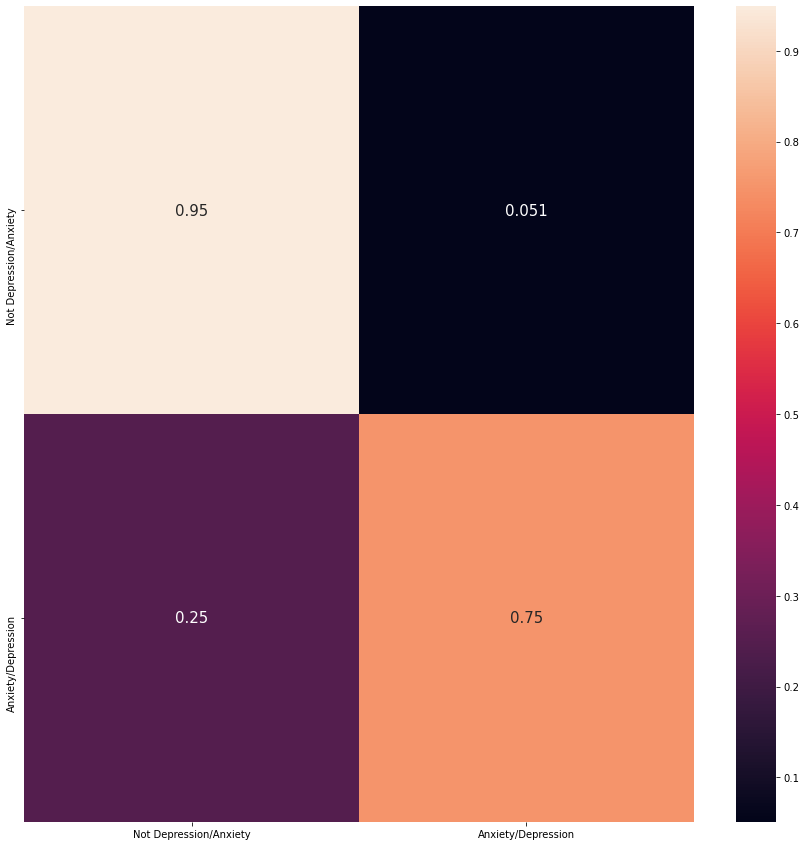

In [34]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, np.around(y_pred, decimals=0))
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Not Depression/Anxiety','Anxiety/Depression'],columns = ['Not Depression/Anxiety','Anxiety/Depression'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

It achieved very good results - at least to be a so simple model, but seems like it cannot interpret very good the underlying text structure. Let's try a more complex network

## Model 2
We'll stack to LSTM layers and increase a little bit the embedding dimension. Let's see how it performs.

In [35]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40))
model2.add(layers.LSTM(40,dropout=0.5,return_sequences=True))
model2.add(layers.LSTM(40,dropout=0.5))
model2.add(layers.Dense(1,activation='sigmoid'))

model2.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

history = model2.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test))

Epoch 1/5
168/168 [==============================] - 7s 39ms/step - loss: 0.5560 - accuracy: 0.7032 - val_loss: 0.3339 - val_accuracy: 0.8674
Epoch 2/5
168/168 [==============================] - 6s 36ms/step - loss: 0.3291 - accuracy: 0.8669 - val_loss: 0.2790 - val_accuracy: 0.8808
Epoch 3/5
168/168 [==============================] - 6s 37ms/step - loss: 0.2394 - accuracy: 0.9084 - val_loss: 0.2503 - val_accuracy: 0.9032
Epoch 4/5
168/168 [==============================] - 6s 37ms/step - loss: 0.1987 - accuracy: 0.9272 - val_loss: 0.3646 - val_accuracy: 0.8707
Epoch 5/5
168/168 [==============================] - 6s 36ms/step - loss: 0.1683 - accuracy: 0.9410 - val_loss: 0.2497 - val_accuracy: 0.9004


In [36]:
test_loss, test_acc = model2.evaluate(X_test,  y_test, verbose=2)
print('Model accuracy: ',test_acc)

56/56 - 1s - loss: 0.2497 - accuracy: 0.9004
Model accuracy:  0.900391697883606


In [37]:
y_pred = model2.predict(X_test)

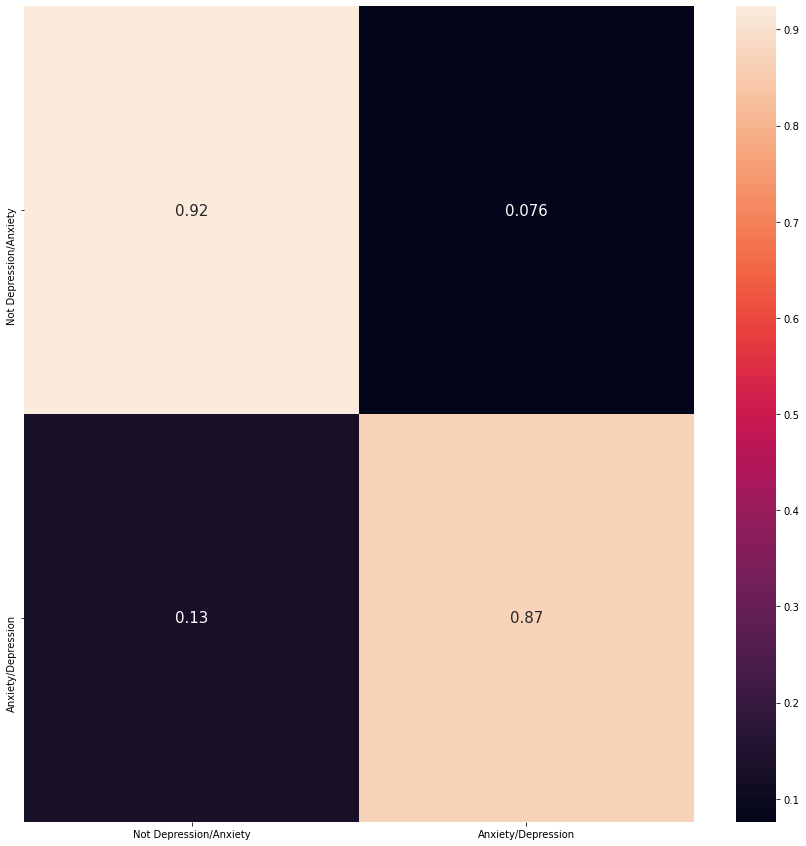

In [38]:
matrix = confusion_matrix(y_test, np.around(y_pred, decimals=0))
conf_matrix = pd.DataFrame(matrix, index = ['Not Depression/Anxiety','Anxiety/Depression'],columns = ['Not Depression/Anxiety','Anxiety/Depression'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

It decreased a little bit the TPs. For this task this wouldn't work for us. Let's try with a very powerful model, usually used for NLP tasks.

# Model 3
We'll implement a Bidirectional LSTM layer. Let's see how it performs.

In [39]:
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40))
model3.add(layers.Bidirectional(layers.LSTM(40,dropout=0.5)))
model3.add(layers.Dense(1,activation='sigmoid'))

model3.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

history = model3.fit(X_train, y_train, epochs=8,validation_data=(X_test, y_test))

Epoch 1/8
168/168 [==============================] - 7s 40ms/step - loss: 0.5764 - accuracy: 0.7003 - val_loss: 0.3969 - val_accuracy: 0.8539
Epoch 2/8
168/168 [==============================] - 6s 36ms/step - loss: 0.3407 - accuracy: 0.8722 - val_loss: 0.2833 - val_accuracy: 0.8780
Epoch 3/8
168/168 [==============================] - 6s 35ms/step - loss: 0.2461 - accuracy: 0.9085 - val_loss: 0.3066 - val_accuracy: 0.8730
Epoch 4/8
168/168 [==============================] - 6s 35ms/step - loss: 0.2069 - accuracy: 0.9267 - val_loss: 0.2403 - val_accuracy: 0.9026
Epoch 5/8
168/168 [==============================] - 6s 38ms/step - loss: 0.1724 - accuracy: 0.9393 - val_loss: 0.2900 - val_accuracy: 0.8836
Epoch 6/8
168/168 [==============================] - 6s 36ms/step - loss: 0.1512 - accuracy: 0.9459 - val_loss: 0.2575 - val_accuracy: 0.8982
Epoch 7/8
168/168 [==============================] - 6s 38ms/step - loss: 0.1510 - accuracy: 0.9492 - val_loss: 0.2968 - val_accuracy: 0.8903
Epoch 

In [40]:
y_pred = model3.predict(X_test)

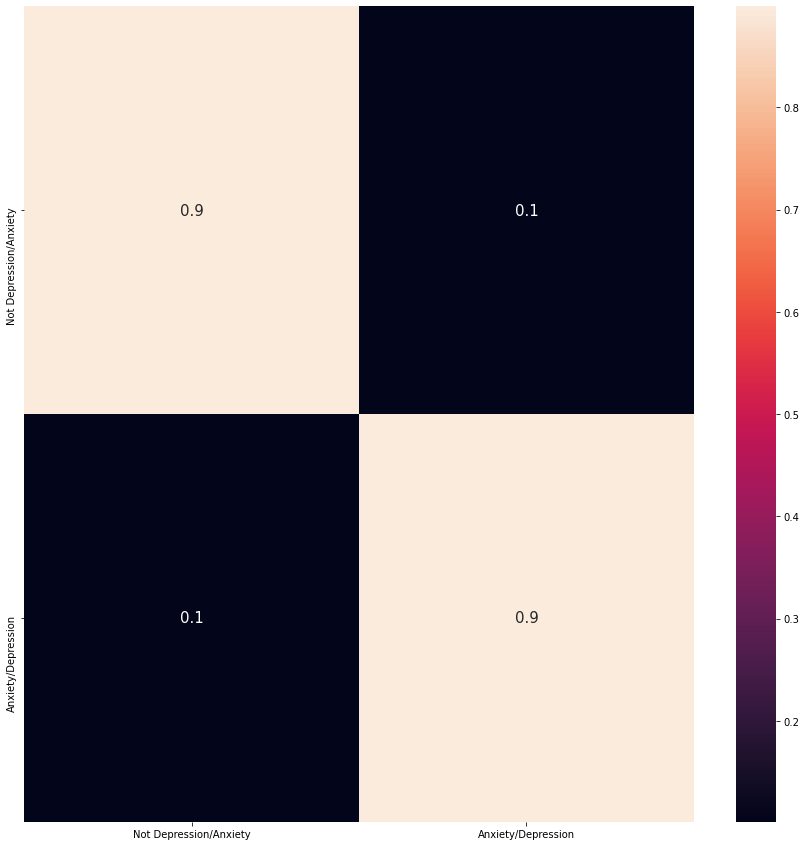

In [41]:
matrix = confusion_matrix(y_test, np.around(y_pred, decimals=0))
conf_matrix = pd.DataFrame(matrix, index = ['Not Depression/Anxiety','Anxiety/Depression'],columns = ['Not Depression/Anxiety','Anxiety/Depression'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

This model performed really well for the data available and delivered better results than the previous ones and its' abvious, this model trains on the data in chronologial and anti-chronological way, just to try to find out deeper patters. **For this oportunity we'll keep the 3rd model, which is the one that delivers better results.** (or at least before the final commit)  - Let's test the model with a sentence including depressive/anxious language.

# Testing the model with depressive/anxious language

In [42]:
test = np.array(['I feel stress, sadness and anxiety - just want to sleep until the lockdown ends'])
test_sequence = tokenizer.texts_to_sequences(test)
test_sequence = pad_sequences(test_sequence, maxlen=max_len)
test_prediction = model3.predict(test_sequence)
if np.around(test_prediction, decimals=0)[0][0] == 1.0:
    print('The model predicted depressive/anxious language')
else:
    print("The model predicted other type of language")

The model predicted other type of language


Fantastic! Let's move on a predict over a much bigger dataset.

# Depressive/Anxious tweets import and exploration

Alright, we're about to explore a dataset that I've acquired implementing OMGOT script - It's essentilly a Python code to get tweets without the need of using the Twitter API. Why did I do it this way? Because in order to use the Twitter API you need a developer account and you all know how complex is to get it approved. In addition, the Twitter API only allows you to retrieve a small quantity of tweets. In the other hand, the mentioned script allows you to get whatever the tweets you want, in the location you want and with the keywords that you want. 

The dataset is made up of several CSV files, each one containing all available tweets related to depression and anxiety topics. We've limited them because would get complex to measure our model in a dataset that contains spread content. Also, the dataset contains tweets from 03/14 to 03/27 - one week before and after the lockdown started along US. Let's see what patterns we can find.

In [43]:
os.listdir('/kaggle/input/depression-anxiety-tweets/Tweets data')[:5]

['0319_2.csv', '0315_1.csv', '0320_4.csv', '0325_2.csv', '0319_4.csv']

In [44]:
tweets = pd.read_csv('/kaggle/input/depression-anxiety-tweets/Tweets data/0314_1.csv')
tweets.head()

,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,2020-03-14 23:55:21,AlbertoxVazquez,NaN,0,1,5,Bout to depression buy these OnlyFans while I’...,NaN,NaN,NaN,1238977045230739460,https://twitter.com/AlbertoxVazquez/status/123...
1,2020-03-14 23:54:45,TheOGKennedy,NaN,6,2,63,Pretty lucky for me how we ended up in the onl...,NaN,NaN,NaN,1238976896160772096,https://twitter.com/TheOGKennedy/status/123897...
2,2020-03-14 23:45:58,megmarie5,NaN,0,0,0,@ariana2525 I myself suffered & still suffer. ...,NaN,@ariana2525,NaN,1238974685015990273,https://twitter.com/megmarie5/status/123897468...
3,2020-03-14 23:43:10,BoozyBillsBabe,NaN,13,0,39,Second full day of self-quarantine and I am ju...,NaN,NaN,NaN,1238973978963836928,https://twitter.com/BoozyBillsBabe/status/1238...
4,2020-03-14 23:42:39,megmarie5,NaN,0,0,1,I’m behind on @VanderpumpRules and binge watch...,NaN,@VanderpumpRules @ariana2525,NaN,1238973850227884032,https://twitter.com/megmarie5/status/123897385...


It's time to explain how the dataset is composed. I queried several tweets from the beginning of the lockdown at US. I focused on downloading tweets that contain the keywords 'Anxiety', 'Depression', 'Anxious' and 'Depressive' in order to limit the topics, otherwise these would be very general. Let's put them all on a same dataframe to start the exploration.

In [45]:
for dirname, _, filenames in os.walk('/kaggle/input/depression-anxiety-tweets/Tweets data'):
    for filename in filenames:
        if filename!='0314_1.csv':
            temp = pd.read_csv(os.path.join(dirname, filename))
            tweets = pd.concat([tweets, temp], ignore_index=True)

In [46]:
tweets.shape

(25425, 12)

In [47]:
tweets.sort_values(by=['date'],inplace=True)
tweets.reset_index(drop=True,inplace=True)
tweets = tweets[['date','text']]

In [48]:
tweets_dataset = tweets.copy()
tweets.head()

,date,text
0,2020-03-14 00:04:13,Damn just remembered this front bottoms show i...
1,2020-03-14 00:07:19,"hapless Dementia joe will lose to Trump, even ..."
2,2020-03-14 00:07:52,it's making me anxious lol
3,2020-03-14 00:08:46,I’m so glad my depression kicked in I’m going ...
4,2020-03-14 00:11:16,Have some wine . You’ll feel less anxious.


In [49]:
#Removing non-ascii characters (for example, arabian chars)
tweets.text.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
#Making all fields string type
for i in range(len(tweets)):
  tweets.at[i,'text'] = str(tweets.iloc[i]['text'])
#Removing URLs
for i in range(len(tweets)):
  tweets.at[i,'text'] = remove_urls(tweets.iloc[i]['text'])
# Convert to list
data = tweets.text.values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [50]:
data = np.array(data)
data[:10]

array(['Damn just remembered this front bottoms show is about to cure my depression',
       'hapless Dementia joe will lose to Trump, even if the economy craters into a full on depression & covid19 kills millions of people. Second you cannot expect to conduct an unfair, corrupt & illegitimate primary & expect people to fall in line. I voted for Hillary last time no mas.',
       'its making me anxious lol',
       'Im so glad my depression kicked in Im going to BED',
       'Have some wine . Youll feel less anxious.',
       'Everyone be patient. Messages blowing up. I know yall are anxious to bet something. I am doing mini write ups on each of the 6 games, because I want to be clear Im not just picking games for fucks sake. Theres a method to my madness. Once you pay, hang tight! Thank you!',
       'Cant wait to tell my kids about the toilet paper depression of 2020',
       'I think in order to keep sick hourly workers home, and to support people who cant work from home but have ki

In [51]:
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[    0     0     0 ...  1058     8    50]
 [    0     0     0 ...   234    65    64]
 [    0     0     0 ...    15   395   594]
 ...
 [    0     0     0 ...  6489  2324  6489]
 [    0     0     0 ... 10138  6728  7872]
 [    0     0     0 ... 10138  6728  7872]]


Let's look for depressive/anxious tweets

In [52]:
predictions = model3.predict(tweets)

In [53]:
np.around(predictions, decimals=0)

array([[1.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [54]:
tweets_dataset['label'] = np.around(predictions, decimals=0)

In [55]:
tweets_dataset[tweets_dataset['label']==1.0].head(10)

,date,text,label
0,2020-03-14 00:04:13,Damn just remembered this front bottoms show i...,1.0
1,2020-03-14 00:07:19,"hapless Dementia joe will lose to Trump, even ...",1.0
6,2020-03-14 00:14:19,Can’t wait to tell my kids about the toilet pa...,1.0
9,2020-03-14 00:15:00,"Right on, dedication is proven to our city. ""W...",1.0
10,2020-03-14 00:20:51,And here we are the Great Depression of toilet...,1.0
11,2020-03-14 00:22:45,Self quarantining and social distancing AKA de...,1.0
12,2020-03-14 00:23:31,Depression is knocking at the door #Tougaloo_R...,1.0
17,2020-03-14 00:28:04,The Great Depression Mode #BandsFromHistory,1.0
18,2020-03-14 00:28:31,"Seasonal depression is a fucking bitch, depres...",1.0
23,2020-03-14 00:35:19,We bouta have the Great Depression all over again,1.0


Let's print some random depressive/anxious tweets to see how well the results are.

In [56]:
for i in range(10):
    print(tweets_dataset.iloc[i*2]['text'])
    print('\n')

Damn just remembered this front bottoms show is about to cure my depression


it's making me anxious lol


Have some wine . You’ll feel less anxious.


Can’t wait to tell my kids about the toilet paper depression of 2020


<——— anxious bunny https://twitter.com/GlennonDoyle/status/1238449159168053250 …


And here we are the Great Depression of toilet paper


Depression is knocking at the door #Tougaloo_RYS20 #Jackson_RYS20https://twitter.com/UnderRatedTim/status/1238589018662715392 …


Take me back! Kind of been in a slight depression since being home. With all this virus crap, it’s making it worse! Kind of hard to return to normal life when people think the world is ending @Atlantis Bahamas https://www.instagram.com/p/B9sZ6Q9HmL-/?igshid=kku0lw1dwunw …


Take me back! Kind of been in a slight depression since being home. With all this virus crap, it’s making it worse! Kind of hard to return to normal life when people think the world is ending @Atlantis Bahamas https://www.instagram.co

# Conclusions

Alright, we've reached the end of this notebook. We went through several steps, including NLP for clustering and classification. What I would like to highlight at this point is that Deep Learning is an approach for when you have tons of data available, otherwise most of the times regular/classic ML models would perform better. As you could see, DL this time delivered an acceptable score, but for any other task such as in medical field, definitely you will need to get more data to increase the recall score. For now, I train the same model with the same data on SageMaker and should get similar results.

Thanks for reading.